# Predator-Prey

Model thanks to [Danilo @danlessa](https://github.com/danlessa/)! See [Lotka-Volterra equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 10) 
import time

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

In [2]:
system_params = {
    'prey_reproduction_rate': [0.3],
    'predator_interaction_factor': np.arange(0.0001, 0.001, 0.000001),
    'prey_interaction_factor': [0.001],
    'prey_death_rate': [0.01],
    'predator_death_rate': [0.5],
    'dt': [0.1]
}

initial_state = {
    'prey_population': 100,
    'predator_population': 100
}

In [3]:
def p_reproduce_prey(params, substep, state_history, prev_state, **kwargs):
    born_population = prev_state['prey_population'] * params['prey_reproduction_rate'] * params['dt']
    return {'add_prey': born_population}


def p_reproduce_predators(params, substep, state_history, prev_state, **kwargs):
    born_population = prev_state['predator_population'] * prev_state['prey_population'] * params['predator_interaction_factor'] * params['dt']
    return {'add_predators': born_population}


def p_eliminate_prey(params, substep, state_history, prev_state, **kwargs):
    population = prev_state['prey_population']
    natural_elimination = population * params['prey_death_rate']
    
    interaction_elimination = population * prev_state['predator_population'] * params['prey_interaction_factor']
    
    eliminated_population = natural_elimination + interaction_elimination * params['dt']
    return {'add_prey': -1.0 * eliminated_population}


def p_eliminate_predators(params, substep, state_history, prev_state, **kwargs):
    population = prev_state['predator_population']
    eliminated_population = population * params['predator_death_rate'] * params['dt']
    return {'add_predators': -1.0 * eliminated_population}


def s_prey_population(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_prey_population = np.ceil(prev_state['prey_population'] + policy_input['add_prey'])
    return ('prey_population', max(updated_prey_population, 0))


def s_predator_population(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_predator_population = np.ceil(prev_state['predator_population'] + policy_input['add_predators'])
    return ('predator_population', max(updated_predator_population, 0))

In [4]:
state_update_blocks = [
    {
        'policies': {
            'reproduce_prey': p_reproduce_prey,
            'reproduce_predators': p_reproduce_predators,
            'eliminate_prey': p_eliminate_prey,
            'eliminate_predators': p_eliminate_predators
        },
        'variables': {
            'prey_population': s_prey_population,
            'predator_population': s_predator_population            
        }
    }

]

In [20]:
TIMESTEPS = 1000
RUNS = 1

### Golem Network Daemon
To be able to use the Golem network, you need to install and run a daemon that communicates with the network. If you are on windows, or if you would like to do a manual install, please go [here](https://handbook.golem.network/requestor-tutorials/flash-tutorial-of-requestor-development#running-the-yagna-daemon)

#### Install

`curl -sSf https://join.golem.network/as-requestor | bash -`

#### Run damon
`yagna service run`

#### Generate App key
`yagna app-key create requestor`

This key needs to be put inside `GOLEM_CONF` under the key `YAGNA_KEY` in the cell below.

You can retrieve your key at a later time if need be by running:

`yagna app-key list`

#### Get test GLM tokens
`yagna payment fund` 

#### Verify tokens have been received
`yagna payment status`

#### Enable daemon as requestor
`yagna payment init --sender`  


### General Use
Post installation, to use Golem, your steps will be as follows:

`yagna service run`

`yagna payment init --sender`

In [6]:
GOLEM_CONF = {
    'YAGNA_KEY': 'f697db164d5e4af6a64a8fa2810bd9d3',
    'NODES': 20,
    #'MEMORY': 0.5,
    #'STORAGE': 2.0,
    #'TIMEOUT': 2,
    #'BUNDLES': 10,
    #'BUDGET': 10,
    #'SUBNET_TAG': 'community.4',
    #'PAYMENT_DRIVER': 'zksync',
    #'NETWORK': 'rinkeby',
    #'LOG_FILE': 'radcad_golem.log',
    #'DEBUG_ACTIVITY': False,
    #'DEBUG_MARKET': False,
    #'DEBUG_PAYMENT': False
}

In [7]:
model = Model(initial_state=initial_state, state_update_blocks=state_update_blocks, params=system_params)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)
experiment = Experiment(simulation)
# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
experiment.engine = Engine(backend=Backend.GOLEM, golem_conf=GOLEM_CONF)

result = experiment.run()

[2021-03-05 19:35:36,202 INFO yapapi] Using log file `radcad_golem.log`; in case of errors look for additional information there
yapapi version: 0.5.0
Using subnet: community.4, payment driver: zksync, and network: rinkeby
[2021-03-05 19:35:56,933 WARNING yapapi.summary] 6 offers have been collected from the market, but no provider has responded for 20s. Make sure you're using the latest released versions of yagna and yapapi, and the correct subnet. Also make sure that the timeout for computing all tasks is within the 5 min to 30 min range.
[2021-03-05 19:36:00,062 INFO yapapi.summary] Received proposals from 1 providers so far
[2021-03-05 19:36:00,445 INFO yapapi.summary] Received proposals from 2 providers so far
[2021-03-05 19:36:00,454 INFO yapapi.summary] Received proposals from 3 providers so far
[2021-03-05 19:36:00,458 INFO yapapi.summary] Received proposals from 4 providers so far
[2021-03-05 19:36:00,472 INFO yapapi.summary] Received proposals from 5 providers so far
[2021-03

Task computed: Task(id=1, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_0.pickle.procd, time: 0:00:13.429337


[2021-03-05 19:36:33,642 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle
[2021-03-05 19:36:33,787 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle


Task computed: Task(id=2, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_1.pickle.procd, time: 0:00:09.514019


[2021-03-05 19:36:42,540 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle
[2021-03-05 19:36:42,663 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle


Task computed: Task(id=3, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_2.pickle.procd, time: 0:00:08.896477


[2021-03-05 19:36:51,709 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle
[2021-03-05 19:36:51,844 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle


Task computed: Task(id=4, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_3.pickle.procd, time: 0:00:09.170510


[2021-03-05 19:37:00,721 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle
[2021-03-05 19:37:00,840 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_5.pickle


Task computed: Task(id=5, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_4.pickle.procd, time: 0:00:09.012827


[2021-03-05 19:37:09,475 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_5.pickle
[2021-03-05 19:37:09,587 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_6.pickle


Task computed: Task(id=6, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_5.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_5.pickle.procd, time: 0:00:08.752192


[2021-03-05 19:37:18,532 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_6.pickle
[2021-03-05 19:37:18,647 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_7.pickle


Task computed: Task(id=7, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_6.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_6.pickle.procd, time: 0:00:09.058438


[2021-03-05 19:37:27,261 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_7.pickle
[2021-03-05 19:37:27,331 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_8.pickle


Task computed: Task(id=8, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_7.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_7.pickle.procd, time: 0:00:08.728202


[2021-03-05 19:37:35,892 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_8.pickle


Task computed: Task(id=9, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_8.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_8.pickle.procd, time: 0:00:08.631022


[2021-03-05 19:37:36,175 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_9.pickle
[2021-03-05 19:37:42,001 INFO yapapi.summary] Received proposals from 9 providers so far
[2021-03-05 19:37:42,077 INFO yapapi.summary] Received proposals from 10 providers so far
[2021-03-05 19:37:44,710 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_9.pickle
[2021-03-05 19:37:44,823 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_10.pickle


Task computed: Task(id=10, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_9.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_9.pickle.procd, time: 0:00:08.816860


[2021-03-05 19:37:53,530 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_10.pickle
[2021-03-05 19:37:53,687 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_11.pickle


Task computed: Task(id=11, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_10.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_10.pickle.procd, time: 0:00:08.818521


[2021-03-05 19:38:02,481 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_11.pickle
[2021-03-05 19:38:02,595 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_12.pickle


Task computed: Task(id=12, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_11.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_11.pickle.procd, time: 0:00:08.952526


[2021-03-05 19:38:11,462 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_12.pickle
[2021-03-05 19:38:11,546 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_13.pickle


Task computed: Task(id=13, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_12.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_12.pickle.procd, time: 0:00:08.980636


[2021-03-05 19:38:20,750 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_13.pickle
[2021-03-05 19:38:20,876 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_14.pickle


Task computed: Task(id=14, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_13.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_13.pickle.procd, time: 0:00:09.286825


[2021-03-05 19:38:29,770 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_14.pickle
[2021-03-05 19:38:29,891 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_15.pickle


Task computed: Task(id=15, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_14.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_14.pickle.procd, time: 0:00:09.019721


[2021-03-05 19:38:38,878 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_15.pickle
[2021-03-05 19:38:38,990 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_16.pickle


Task computed: Task(id=16, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_15.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_15.pickle.procd, time: 0:00:09.108252


[2021-03-05 19:38:47,686 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_16.pickle
[2021-03-05 19:38:47,800 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_17.pickle


Task computed: Task(id=17, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_16.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_16.pickle.procd, time: 0:00:08.807394


[2021-03-05 19:38:56,776 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_17.pickle


Task computed: Task(id=18, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_17.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_17.pickle.procd, time: 0:00:09.089137


[2021-03-05 19:38:57,075 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_18.pickle
[2021-03-05 19:39:05,640 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_18.pickle
[2021-03-05 19:39:05,754 INFO yapapi.summary] Task sent to provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_19.pickle


Task computed: Task(id=19, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_18.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_18.pickle.procd, time: 0:00:08.864152


[2021-03-05 19:39:14,315 INFO yapapi.summary] Task computed by provider 'yagna-ryzen-mixma01', task data: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_19.pickle
[2021-03-05 19:39:14,324 INFO yapapi.summary] Computation finished in 217.5s
[2021-03-05 19:39:14,327 INFO yapapi.summary] Negotiated 2 agreements with 2 providers
[2021-03-05 19:39:14,329 INFO yapapi.summary] Provider 'yagna-ryzen-mixma01' computed 20 tasks
[2021-03-05 19:39:14,334 INFO yapapi.summary] Provider 'cristobalito-probando' did not compute any tasks
[2021-03-05 19:39:14,336 INFO yapapi.summary] Provider 'pawelek_666' did not compute any tasks


Task computed: Task(id=20, data=/home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_19.pickle), result: /home/roger/projects/radcad/repo/radCAD/radcad/extensions/backends/golem/pickles/bundle_19.pickle.procd, time: 0:00:08.676694


[2021-03-05 19:39:25,313 INFO yapapi.summary] Total cost: 0.005194732811922223
[2021-03-05 19:39:25,314 INFO yapapi.summary] Executor has shut down


20 tasks computed, total time: 0:03:49.027694


In [8]:
df = pd.DataFrame(result)
df

,prey_population,predator_population,simulation,subset,run,substep,timestep
0,100.0,100.0,0,0,1,0,0
1,101.0,96.0,0,0,1,1,1
2,103.0,92.0,0,0,1,1,2
3,105.0,88.0,0,0,1,1,3
4,107.0,84.0,0,0,1,1,4
...,...,...,...,...,...,...,...
900895,527.0,302.0,0,899,1,1,996
900896,522.0,303.0,0,899,1,1,997
900897,517.0,304.0,0,899,1,1,998
900898,512.0,305.0,0,899,1,1,999


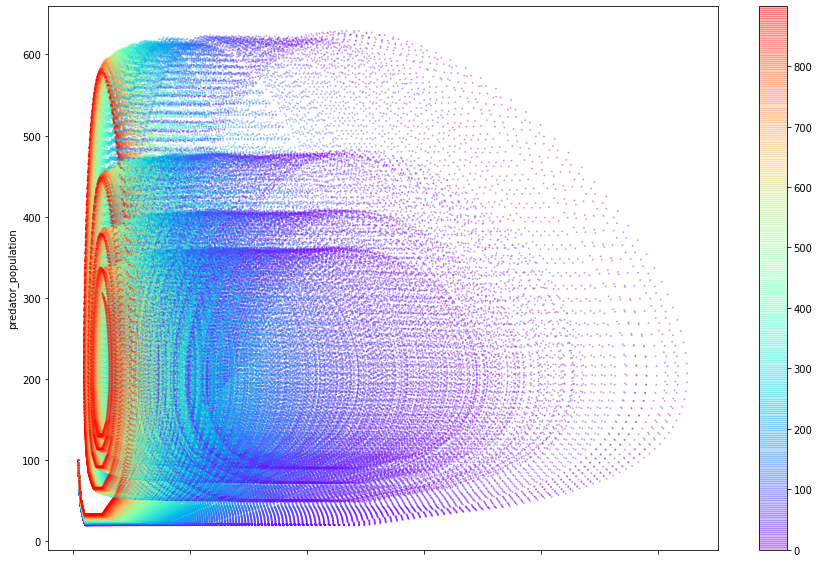

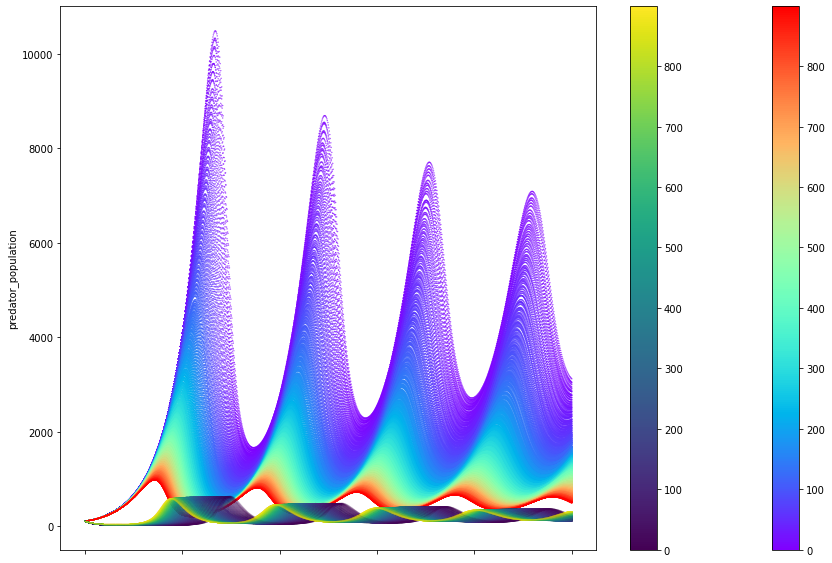

In [19]:
df.plot.scatter(
    x='prey_population',
    y='predator_population',
    color=df['subset'],
    s=1,
    colormap='rainbow' ,
    alpha=0.3
)

ax = df.plot.scatter(
    x='timestep',
    y='prey_population',
    color=df['subset'],
    s=0.1,
    colormap='rainbow' ,
)

df.plot.scatter(
    x='timestep',
    y='predator_population',
    color=df['subset'],
    s=0.001,
    colormap='viridis',
    ax=ax
);